In [1]:
"""
July 22, 2020

Comparing parameter results of MCMCs.
"""

import ares
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.patches import Rectangle
import itertools

In [2]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
     
    'pq_func_par0[0]_err',
    'pq_func_par2[0]_err', 

    #norm
    'pq_func_par0[1]_err',
    'pq_func_par2[1]_err', 

    #gamma
    'pq_func_par0[2]_err',
    'pq_func_par2[2]_err', 

    #peak mass
    'pq_func_par0[3]_err',
    'pq_func_par2[3]_err' 
]

labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

In [3]:
def getData(text):
    results = np.loadtxt(text, delimiter=',')
    runs = int(len(results)/9)

    results = np.reshape(results, (runs, 9, 3))
    
    #make a dictionary for easy access
    resDict = {}

    for e in results:
        
        pars_update = {}

        resDict[str(e[0][0])] = {}

        resDict[str(e[0][0])]['zLow'] = e[0][1]
        resDict[str(e[0][0])]['zHigh'] = e[0][2]

        for i in range(1, 9):
            resDict[str(e[0][0])][params[i-1]] = e[i][0]
            pars_update[params[i-1]] = e[i][0]
        for i in range(1, 9):
            resDict[str(e[0][0])][params[i+7]] = e[i][1:]
            
        #and a galaxyHOD object for plotting
        pars = ares.util.ParameterBundle("emma:model1")

        pars.update(pars_update)
        
        resDict[str(e[0][0])]["pop"] = ares.populations.GalaxyPopulation(**pars)
            
    return resDict

In [4]:
colors = ['blue', 'orange', 'teal', 'darkgreen', 'purple', 'cyan', 'crimson', 'violet']

pars = ares.util.ParameterBundle("emma:model1")
popPaper = ares.populations.GalaxyPopulation(**pars)

def plotSMF(DataD, z):
    pl.figure(figsize=(8, 5))
    Ms = np.linspace(7, 12, 80)

    obslf = ares.analysis.GalaxyPopulation()
    ax = obslf.PlotSMF(z=z, round_z=0.2, log10Mass=True)

    for i, e in enumerate(DataD):

        smf = DataD[e]['pop'].StellarMassFunction(z, Ms)
        Zrange ="{0}-{1}".format(DataD[e]['zLow'], DataD[e]['zHigh'])
        if smf[0] == -np.inf:
            print("-inf results: {}!".format(e))

        ax.semilogy(Ms, smf, label=Zrange, color=colors[i])

    pl.title("z = %.2f" %z)
    pl.legend()
    # pl.ylim(1e-15, 1e2)
    pl.show()
    
def plotParams(DataD, err=True, paper=True, ave=True, printErr=False):
    #negative errors are from the value being out of the 68% range of the histogram

    fig, axs = pl.subplots(2, 4, figsize=(17, 10))
    
    aveA = []

    for i, ax in enumerate(axs.flat):
        
        vals = []
        for j, e in enumerate(DataD): 
            ax.hlines(y=DataD[e][params[i]], xmin=DataD[e]['zLow'], xmax=DataD[e]['zHigh'], color=colors[j])

            if err:
                if DataD[e][params[i+8]][0] < 0 or DataD[e][params[i+8]][1] < 0:
                    if printErr:
                        print("Negative Error: {}, {}".format(e, labels[params[i]]))
                else:
                    rect = Rectangle((DataD[e]['zLow'], DataD[e][params[i]]-DataD[e][params[i+8]][1]), 
                                 width=DataD[e]['zHigh']-DataD[e]['zLow'], 
                                 height=DataD[e][params[i+8]][1] + DataD[e][params[i+8]][0], color=colors[j], alpha=0.2)
                    ax.add_patch(rect)
                
            vals.append(DataD[e][params[i]])

        ax.set_title(labels[params[i]])

        if paper:
            ax.hlines(y=pars[params[i]], xmin=0, xmax=3.5, color='black', ls="--")
            
        aveA.append(np.average(vals, weights=None))
        
        if ave:
            ax.hlines(y=aveA[-1], xmin=0, xmax=4.0, color='grey', ls="--")
        
        ax.set(xlabel='z')#, ylabel='Val')
        ax.set_xlim(0, 4)
    pl.show()
    
    return aveA

In [5]:
N = lambda z, N_0, nu: N_0 * (z + 1)**nu
M_1 = lambda z, logM_0, mu: 10**(logM_0*(z+1)**mu)
beta = lambda z, beta_0, beta_1: beta_1*z+beta_0
gamma = lambda z, gamma_0, gamma_1: gamma_0*(z + 1)**gamma_1

newM_1 = lambda z, logM_0, mu: 10**(logM_0) *(z+1)**mu

func = [beta, N, gamma, M_1]
funcName = ['$\\beta$', 'Norm', '$\gamma$', '$M_1$']

def paramsRedshiftEvolve(DataD, paper=True, newMu=False):
    #Redshift-dependent parameterizations
    
    z = np.linspace(0, 4, 50)

    fig, axs = pl.subplots(2, 2, figsize=(17, 10))
    
    aveA = []

    for i, ax in enumerate(axs.flat):
        
        vals = []
        for j, e in enumerate(DataD): 
            
            if i == 3:
                pl.yscale('log')
#                 ax.set_ylim(0, 1e100)
                if newMu:
                    y = newM_1(z, DataD[e][params[2*i]], DataD[e][params[2*i + 1]]) 
            
            y = func[i](z, DataD[e][params[2*i]], DataD[e][params[2*i + 1]])
            
            ax.plot(z, y, color=colors[j])

            ax.set_title(funcName[i])
            
        if paper:

            y = func[i](z, pars[params[2*i]], pars[params[2*i+1]])
            
            ax.plot(z, y, color='black', ls="--")
                
        ax.set(xlabel='z')#, ylabel='Val')
        ax.set_xlim(0, 4)

    pl.show()    
    

In [8]:
# text = "CedarScripts/testingP.txt"
text = "../Cedar/Output_47324900.txt"
# text = "../Cedar/OutputArr_24-07.txt"
# text = "../Cedar/Output_47216338.txt"
# text = "../Cedar/OutputArr_004_newMu.txt"

testData = getData(text)

# testData

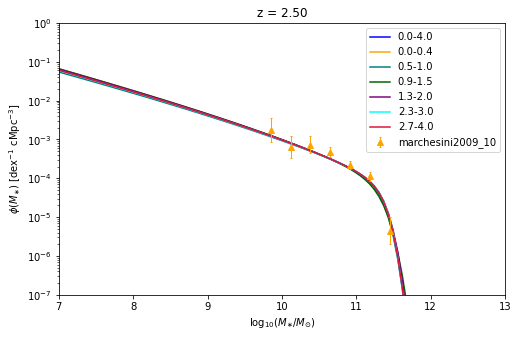

In [19]:
plotSMF(testData, 2.5)

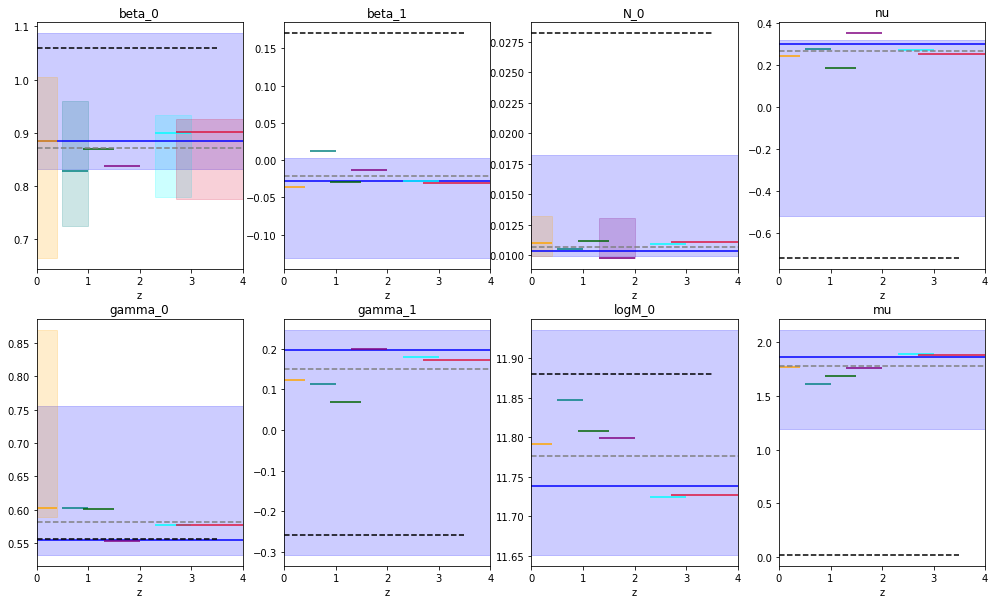

In [10]:
ave = plotParams(testData, err=True, printErr=False)

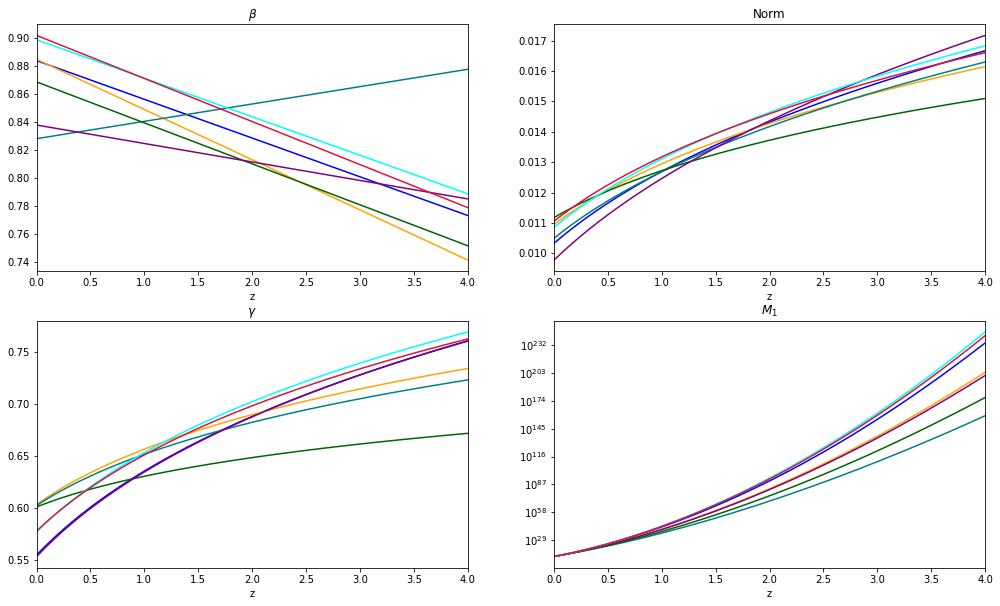

In [15]:
paramsRedshiftEvolve(testData, newMu=True, paper=False)